In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QuantizedConv2d(nn.Module):
    def __init__(self, conv_layer):
        super().__init__()
        self.in_channels = conv_layer.in_channels
        self.out_channels = conv_layer.out_channels
        self.kernel_size = conv_layer.kernel_size
        self.stride = conv_layer.stride
        self.padding = conv_layer.padding
        self.dilation = conv_layer.dilation
        self.groups = conv_layer.groups
        
        self.quantize_weights(conv_layer.weight)
        
        if conv_layer.bias is not None:
            self.bias = nn.Parameter(conv_layer.bias)
        else:
            self.bias = None

    def quantize_weights(self, weights):
        min_val = weights.min().item()
        max_val = weights.max().item()
        scale = (max_val - min_val) / 255.0
        q_weights = torch.round((weights - min_val) / scale).clamp(0, 255).to(torch.uint8)
        
        self.register_buffer('q_weights', q_weights)
        self.register_buffer('scale', torch.tensor(scale))
        self.register_buffer('zero_point', torch.tensor(min_val))

    def forward(self, x):
        # Переносим параметры на устройство и тип входных данных
        device = x.device
        dtype = x.dtype
        
        scale = self.scale.to(device)
        zero_point = self.zero_point.to(device)
        q_weights = self.q_weights.to(device)
        
        # Деквантуем веса и преобразуем к типу входных данных
        weights = scale * q_weights.float() + zero_point
        weights = weights.to(dtype)
        
        # Обрабатываем смещение
        bias = self.bias.to(device).to(dtype) if self.bias is not None else None
        
        return F.conv2d(
            x, weights, bias, 
            self.stride, self.padding, 
            self.dilation, self.groups
        )

class QuantizedConvTranspose2d(nn.Module):
    def __init__(self, conv_transpose_layer):
        super().__init__()
        self.in_channels = conv_transpose_layer.in_channels
        self.out_channels = conv_transpose_layer.out_channels
        self.kernel_size = conv_transpose_layer.kernel_size
        self.stride = conv_transpose_layer.stride
        self.padding = conv_transpose_layer.padding
        self.output_padding = conv_transpose_layer.output_padding
        self.dilation = conv_transpose_layer.dilation
        self.groups = conv_transpose_layer.groups
        
        self.quantize_weights(conv_transpose_layer.weight)
        
        if conv_transpose_layer.bias is not None:
            self.bias = nn.Parameter(conv_transpose_layer.bias)
        else:
            self.bias = None

    def quantize_weights(self, weights):
        min_val = weights.min().item()
        max_val = weights.max().item()
        scale = (max_val - min_val) / 255.0
        q_weights = torch.round((weights - min_val) / scale).clamp(0, 255).to(torch.uint8)
        
        self.register_buffer('q_weights', q_weights)
        self.register_buffer('scale', torch.tensor(scale))
        self.register_buffer('zero_point', torch.tensor(min_val))

    def forward(self, x):
        # Переносим параметры на устройство и тип входных данных
        device = x.device
        dtype = x.dtype
        
        scale = self.scale.to(device)
        zero_point = self.zero_point.to(device)
        q_weights = self.q_weights.to(device)
        
        # Деквантуем веса и преобразуем к типу входных данных
        weights = scale * q_weights.float() + zero_point
        weights = weights.to(dtype)
        
        # Обрабатываем смещение
        bias = self.bias.to(device).to(dtype) if self.bias is not None else None
        
        return F.conv_transpose2d(
            x, weights, bias, 
            self.stride, self.padding, 
            self.output_padding, self.groups, self.dilation
        )

def quantize_model(model):
    """Рекурсивно применяет квантизацию ко всем сверточным слоям модели"""
    # print("Рекурсивно применяет квантизацию ко всем сверточным слоям модели")
    for name, child in model.named_children():
        if isinstance(child, nn.Conv2d):
            # Заменяем Conv2d на квантизованную версию
            # print("Заменяем Conv2d на квантизованную версию...")
            setattr(model, name, QuantizedConv2d(child))
        elif isinstance(child, nn.ConvTranspose2d):
            # Заменяем ConvTranspose2d
            # print("Заменяем ConvTranspose2d...")
            setattr(model, name, QuantizedConvTranspose2d(child))
        else:
            # Рекурсивный вызов для вложенных модулей
            quantize_model(child)

In [2]:
# from wav2lip import Wav2Lip
# import copy

# quantize = True
# half = False

# device = 'cuda'
# batch_size = 1
# model_ = Wav2Lip()
# model = copy.deepcopy(model_)
# mel = torch.randn(batch_size, 1, 80, 16)
# face = torch.randn(batch_size, 6, 96, 96)
# if half:
#     model = model.half()
#     mel = mel.half()
#     face = face.half()
# if quantize:
#     quantize_model(model)
# model.eval()

# mel = mel.to(device)      # аудио
# face = face.to(device)     # лицо (примерный размер 96x96)
# model = model.to(device)

In [3]:
# with torch.no_grad():
#     torch.cuda.reset_peak_memory_stats(device)
#     out = model(mel, face)
#     print("Peak memory (MB):", torch.cuda.max_memory_allocated(device) / 1024**2)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from wav2lip import Wav2Lip
import copy

def compare_quantization(model, face_input, mel_input, device='cuda', half=False):
    """
    Сравнивает результаты модели с квантизацией и без
    
    Параметры:
    model - оригинальная модель Wav2Lip
    face_input - входной тензор лица
    mel_input - входной тензор аудио
    device - устройство для вычислений
    half - использовать ли float16
    """
    # Клонируем модель для чистоты эксперимента
    model_orig = type(model)()
    model_orig.load_state_dict(model.state_dict())
    model_quant = type(model)()
    model_quant.load_state_dict(model.state_dict())
    
    # Подготовка моделей
    models = {
        "Original": model_orig,
        "Quantized": model_quant
    }
    
    # Применяем квантизацию только ко второй модели
    quantize_model(models["Quantized"])
    
    if half:
        for name, m in models.items():
            m = m.half()
    
    # Перенос моделей и данных на устройство
    results = {}
    for name, m in models.items():
        m.eval()
        m.to(device)
        with torch.no_grad():
            # Перенос входных данных с учетом типа
            face = face_input.clone().to(device)
            mel = mel_input.clone().to(device)
            
            if half:
                face = face.half()
                mel = mel.half()
                
            output = m(mel, face)
            results[name] = output.detach().cpu()
    
    # Вычисляем различия
    orig_tensor = results["Original"].float()
    quant_tensor = results["Quantized"].float()
    
    diff = {
        "MSE": torch.mean((orig_tensor - quant_tensor) ** 2).item(),
        "MAE": torch.mean(torch.abs(orig_tensor - quant_tensor)).item(),
        "Max Error": torch.max(torch.abs(orig_tensor - quant_tensor)).item(),
        "Min Error": torch.min(torch.abs(orig_tensor - quant_tensor)).item(),
        "PSNR": 10 * torch.log10(1 / torch.mean((orig_tensor - quant_tensor) ** 2)).item()
    }
    
    # Визуализация результатов
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Оригинальный вывод
    orig_img = make_grid(orig_tensor[0], nrow=1, normalize=True, value_range=(-1, 1)).permute(1, 2, 0).numpy()
    axes[0].imshow(np.clip(orig_img, 0, 1))
    axes[0].set_title("Original Output")
    axes[0].axis('off')
    
    # Квантизированный вывод
    quant_img = make_grid(quant_tensor[0], nrow=1, normalize=True, value_range=(-1, 1)).permute(1, 2, 0).numpy()
    axes[1].imshow(np.clip(quant_img, 0, 1))
    axes[1].set_title("Quantized Output")
    axes[1].axis('off')
    
    # Различия (усиленные для визуализации)
    diff_img = make_grid(torch.abs(orig_tensor - quant_tensor)[0], nrow=1, normalize=True).permute(1, 2, 0).numpy()
    axes[2].imshow(diff_img, cmap='hot')
    axes[2].set_title("Difference (Enhanced)")
    axes[2].axis('off')
    
    # Отображение метрик
    metrics_text = "\n".join([f"{k}: {v:.6f}" for k, v in diff.items()])
    plt.figtext(0.5, 0.05, metrics_text, ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    
    plt.suptitle("Quantization Comparison", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()
    
    return diff, results

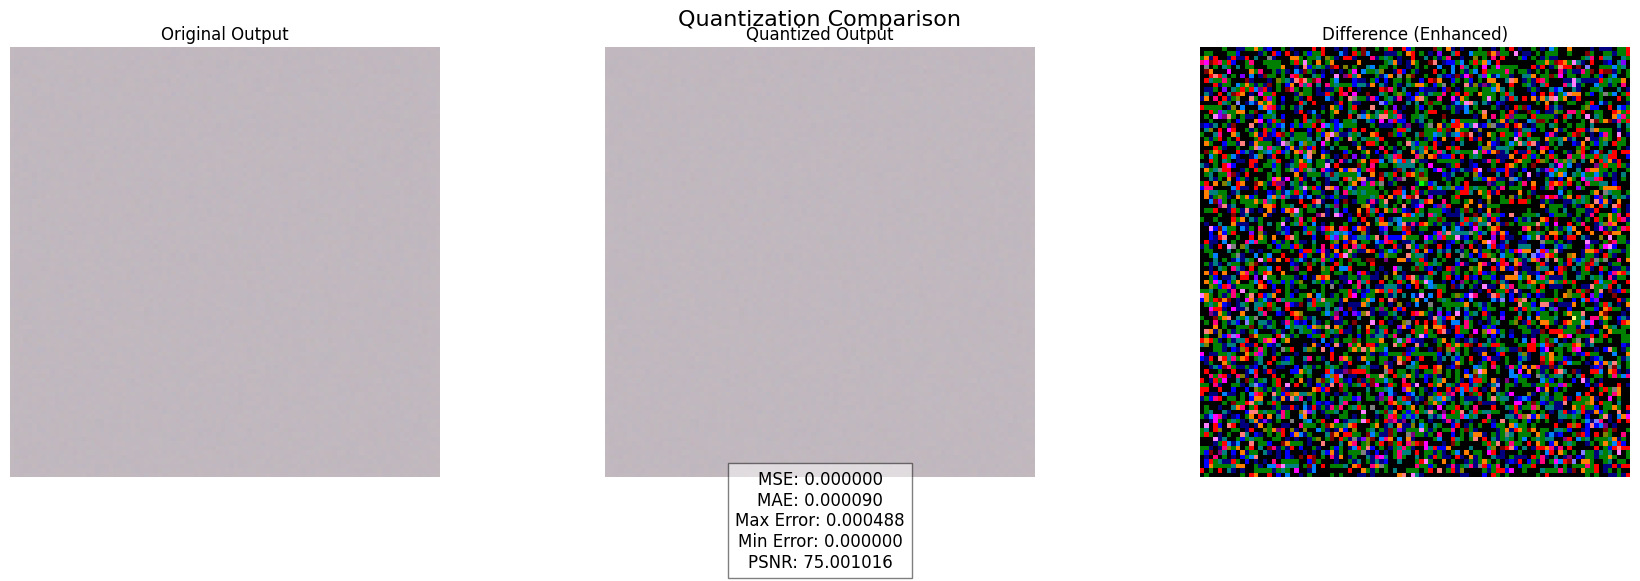


Quantization Metrics:
MSE: 0.000000
MAE: 0.000090
Max Error: 0.000488
Min Error: 0.000000
PSNR: 75.001016


In [5]:
# Предварительная настройка
device = 'cuda'
batch_size = 1
half = True

# Создаем модель и загружаем веса (предположим, что модель уже инициализирована)
model = Wav2Lip()
model.eval()

# Создаем тестовые данные
mel = torch.randn(batch_size, 1, 80, 16)
face = torch.randn(batch_size, 6, 96, 96)

# При необходимости переводим в half
if half:
    model = model.half()
    mel = mel.half()
    face = face.half()

# Перенос на устройство
model.to(device)
mel = mel.to(device)
face = face.to(device)

# Запуск сравнения
diff_metrics, outputs = compare_quantization(
    model=model,
    face_input=face,
    mel_input=mel,
    device=device,
    half=half,
)

# Вывод метрик
print("\nQuantization Metrics:")
for metric, value in diff_metrics.items():
    print(f"{metric}: {value:.6f}")